In [850]:
import requests
import pandas as pd
from dotenv import load_dotenv
import os
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import ast


In [851]:
load_dotenv()
OPENSEA_API = os.getenv('OPENSEA_API_KEY')

In [852]:
def requests_session_with_retries():
    session = requests.Session()
    retries = Retry(total=5,  # Total number of retries to allow.
                    backoff_factor=1,  # A backoff factor to apply between attempts.
                    status_forcelist=[500, 502, 503, 504])  # A set of HTTP status codes that we should force a retry on.
    adapter = HTTPAdapter(max_retries=retries)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session

In [853]:
def fetch_api_data_paginated(base_url, headers=None, data_key='asset_events'):
    session = requests_session_with_retries()
    all_data = []
    url = base_url
    
    while url:
        print(f"Requesting URL: {url}")
        response = session.get(url, headers=headers, timeout=30)
       
        if response.status_code == 200:
            data = response.json()
            page_data = data.get(data_key, [])
            all_data.extend(page_data)
            next_cursor = data.get('next', "")
            print(next_cursor)
            if next_cursor:
                url = f"{base_url}&next={next_cursor}"
            else:
                url = None
        else:
            print(f"Failed to fetch data from {url} - Status Code: {response.status_code}")
            break
        
    return pd.json_normalize(all_data)  # Convert the aggregated data to a DataFrame


In [854]:
# Function to fetch data from an API
def fetch_api_data(url, headers=None):
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()  # Return the JSON data directly
    else:
        print(f"Failed to fetch data from {url}")
        return None


In [855]:
# USER CHOOSES COLLECTION
collection_slug = input("Enter the collection: ")
APR = input("Enter your target APR: ")

# API's
get_collection_stats = f"https://api.opensea.io/api/v2/collections/{collection_slug}/stats"
get_collection = f"https://api.opensea.io/api/v2/collections/{collection_slug}"
get_events_by_collection = f"https://api.opensea.io/api/v2/events/collection/{collection_slug}?event_type=sale"
get_nft_by_collection = f"https://api.opensea.io/api/v2/collection/{collection_slug}/nfts"
get_traits = f"https://api.opensea.io/api/v2/traits/{collection_slug}"

headers = {"accept": "application/json", "x-api-key": OPENSEA_API}

collection_stats_json = fetch_api_data(get_collection_stats, headers)
# traits_df = fetch_api_data(get_traits, headers)


In [856]:
if collection_stats_json:
    # Directly create a DataFrame for 'total' data
    total_data = pd.DataFrame([collection_stats_json['total']])
    
    # Create a DataFrame for 'intervals' data
    intervals_data = pd.DataFrame(collection_stats_json['intervals'])

In [857]:
total_data

,volume,sales,average_price,num_owners,market_cap,floor_price,floor_price_symbol
0,1.489741e+06,46901,31.763526,5278,163321.404693,13.649,ETH


In [858]:
intervals_data

,interval,volume,volume_diff,volume_change,sales,sales_diff,average_price
0,one_day,2677.261855,150.0,2.715678,193,3.488372,13.871823
1,seven_day,8772.113855,311.0,0.929090,537,0.000000,16.335408
2,thirty_day,27059.111555,753.0,0.817103,1357,0.000000,19.940392


In [859]:
# Ensure numeric columns are correctly typed
numeric_cols_total = ['volume', 'sales', 'average_price', 'num_owners', 'market_cap', 'floor_price']
total_data[numeric_cols_total] = total_data[numeric_cols_total].apply(pd.to_numeric, errors='coerce')


In [860]:
total_data.isnull().any()

volume                False
sales                 False
average_price         False
num_owners            False
market_cap            False
floor_price           False
floor_price_symbol    False
dtype: bool

In [861]:
# Convert 'volume_change' and 'sales_diff' to numeric types, handling any errors
numeric_cols_intervals = ['volume', 'volume_diff', 'volume_change', 'sales', 'sales_diff', 'average_price']
intervals_data[numeric_cols_intervals] = intervals_data[numeric_cols_intervals].apply(pd.to_numeric, errors='coerce')

In [862]:
intervals_data.isnull().any()

interval         False
volume           False
volume_diff      False
volume_change    False
sales            False
sales_diff       False
average_price    False
dtype: bool

In [863]:
intervals_data['interval'] = intervals_data['interval'].astype('category')

In [864]:
intervals_data['volume_pct_change'] = intervals_data['volume'].pct_change() * 100
intervals_data['sales_pct_change'] = intervals_data['sales'].pct_change() * 100

In [865]:
intervals_data['volume_pct_change']

0           NaN
1    227.652442
2    208.467400
Name: volume_pct_change, dtype: float64

In [866]:
intervals_data['sales_pct_change']

0           NaN
1    178.238342
2    152.700186
Name: sales_pct_change, dtype: float64

In [867]:
collection_json = fetch_api_data(get_collection, headers)

In [868]:
# Assuming `data` is the JSON response dictionary you received from the API
collection_data = {
    "collection": collection_json["collection"],
    "name": collection_json["name"],
    "description": collection_json["description"],
    "image_url": collection_json["image_url"],
    "banner_image_url": collection_json["banner_image_url"],
    "owner": collection_json["owner"],
    "safelist_status": collection_json["safelist_status"],
    "category": collection_json["category"],
    "is_disabled": collection_json["is_disabled"],
    "is_nsfw": collection_json["is_nsfw"],
    "trait_offers_enabled": collection_json["trait_offers_enabled"],
    "collection_offers_enabled": collection_json["collection_offers_enabled"],
    "opensea_url": collection_json["opensea_url"],
    "project_url": collection_json["project_url"],
    "wiki_url": collection_json["wiki_url"],
    "discord_url": collection_json["discord_url"],
    "telegram_url": collection_json["telegram_url"],
    "twitter_username": collection_json["twitter_username"],
    "instagram_username": collection_json["instagram_username"],
    "total_supply": collection_json["total_supply"],
    "created_date": collection_json["created_date"]
}

# Convert this dictionary to a DataFrame if needed
collection_df = pd.DataFrame([collection_data])


In [869]:
collection_df.drop(['image_url', 'banner_image_url', 'owner', 'safelist_status', 'category', 'is_disabled', 'is_nsfw', 'trait_offers_enabled', 'collection_offers_enabled', 'wiki_url', 'discord_url', 'telegram_url', 'twitter_username', 'instagram_username'], axis=1, inplace=True)

In [870]:
collection_df

,collection,name,description,opensea_url,project_url,total_supply,created_date
0,boredapeyachtclub,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,https://opensea.io/collection/boredapeyachtclub,http://www.boredapeyachtclub.com/,9998,2021-04-22


In [871]:
contracts_df = pd.json_normalize(collection_json, 'contracts')
fees_df = pd.json_normalize(collection_json, 'fees')
payment_tokens_df = pd.json_normalize(collection_json, 'payment_tokens')

In [872]:
rarity_df = pd.DataFrame([collection_json['rarity']])

In [873]:
contracts_df

,address,chain
0,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,ethereum


In [874]:
fees_df.drop(['fee', 'required'], axis=1, inplace=True)

In [875]:
fees_df

,recipient
0,0x0000a26b00c1f0df003000390027140000faa719
1,0xa858ddc0445d8131dac4d1de01f834ffcba52ef1


In [876]:
payment_tokens_df.drop(['address'], axis=1, inplace=True)

In [877]:
payment_tokens_df

,symbol,chain,image,name,decimals,eth_price,usd_price
0,ETH,ethereum,https://raw.seadn.io/files/ETH.svg,Ether,18,1.000000000000000,3962.030000000000200000
1,WETH,ethereum,https://raw.seadn.io/files/WETH.svg,Wrapped Ether,18,1.000000000000000,3962.760000000000218000
2,USDC,ethereum,https://raw.seadn.io/files/USDC.svg,USD Coin,6,0.000252170000000,0.998865000000000000
3,APE,ethereum,https://raw.seadn.io/files/APE.svg,ApeCoin,18,0.000572350000000,2.270000000000000000


In [878]:
rarity_df.drop(['strategy_id', 'strategy_version', 'calculated_at'], axis=1, inplace=True)

In [879]:
rarity_df

,max_rank,tokens_scored
0,10000,10000


In [880]:
collection_df.isnull().any()

collection      False
name            False
description     False
opensea_url     False
project_url     False
total_supply    False
created_date    False
dtype: bool

In [881]:
rarity_df.isnull().any()


max_rank         False
tokens_scored    False
dtype: bool

In [882]:
payment_tokens_df.isnull().any()


symbol       False
chain        False
image        False
name         False
decimals     False
eth_price    False
usd_price    False
dtype: bool

In [904]:
collection_df


,collection,name,description,opensea_url,project_url,total_supply,created_date
0,boredapeyachtclub,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,https://opensea.io/collection/boredapeyachtclub,http://www.boredapeyachtclub.com/,9998,2021-04-22


In [884]:
fees_df.isnull().any()

recipient    False
dtype: bool

In [885]:
contracts_df.isnull().any()

address    False
chain      False
dtype: bool

In [886]:
# merged_df = collection_df.merge(payment_tokens_df, on="common_key", how="left")

In [887]:
events_df = fetch_api_data_paginated(get_events_by_collection, headers, data_key='asset_events')

Requesting URL: https://api.opensea.io/api/v2/events/collection/boredapeyachtclub?event_type=sale
LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTAzLTEyKzE2JTNBMTklM0EzNSYtZXZlbnRfdHlwZT1zdWNjZXNzZnVsJi1waz0yMDg3ODA3MzczOA==
Requesting URL: https://api.opensea.io/api/v2/events/collection/boredapeyachtclub?event_type=sale&next=LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTAzLTEyKzE2JTNBMTklM0EzNSYtZXZlbnRfdHlwZT1zdWNjZXNzZnVsJi1waz0yMDg3ODA3MzczOA==
LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTAzLTEyKzE0JTNBNDYlM0E1OSYtZXZlbnRfdHlwZT1zdWNjZXNzZnVsJi1waz0yMDg3NjY4NTYzNA==
Requesting URL: https://api.opensea.io/api/v2/events/collection/boredapeyachtclub?event_type=sale&next=LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTAzLTEyKzE0JTNBNDYlM0E1OSYtZXZlbnRfdHlwZT1zdWNjZXNzZnVsJi1waz0yMDg3NjY4NTYzNA==
LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTAzLTExKzIzJTNBMTAlM0EyMyYtZXZlbnRfdHlwZT1zdWNjZXNzZnVsJi1waz0yMDg2MTY3NDE4MA==
Requesting URL: https://api.opensea.io/api/v2/events/collection/boredapeyachtclub?event_type=sale&next=LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTAzLTExKzIzJTNBMTAl

In [893]:
events_df.head()

,event_type,order_hash,chain,protocol_address,closing_date,quantity,seller,buyer,transaction,event_timestamp,...,nft.opensea_url,nft.updated_at,nft.is_disabled,nft.is_nsfw,payment.quantity,payment.token_address,payment.decimals,payment.symbol,nft,payment
0,sale,0x9b952c66f6480e8a3217f136476eb2df93b579395cd5...,ethereum,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,1710276059,1,0xf15c93562bc3944a68e938ef75d2a3360d98ca57,0xc95086539f40ae4c658d64c5d159bac00da24fe8,0xed2fcd41c0d0e3072929261b073a7a5ae535541faf99...,1710276059,...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T20:41:01.943308,False,False,14950000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH,NaN,NaN
1,sale,0x34ff577d8bdd2d7be571d294330dad1b05582b626d2d...,ethereum,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,1710274307,1,0x9727e451546e8d2103d432967796904164477d9a,0x52236918af7bc85d654837b568498dde6ce1407c,0x4e62465bd79c4b6e801ce0aa65924611d3ab1af0d031...,1710274307,...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T20:24:41.305650,False,False,13390000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH,NaN,NaN
2,sale,,ethereum,,1710273827,1,0x5ecbd537c5fa12545991ab4e4f4c545fcd996ee2,0x2383d2523d0c9dd42d00957168b2ba0eeface1b9,0x74557d6eba718af83452aed1b2b567928a119186f77f...,1710273827,...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T20:03:51.419185,False,False,13600000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH,NaN,NaN
3,sale,0x95691166e0016eb053716737ef964a861885bb1cc8db...,ethereum,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,1710272639,1,0x0e73d837b29ac157d072c946ad65d3fa9a5750ba,0x63ac40bea352df57f460c391af0a512105c142ef,0xbc7860309062b6fbd6285bd5e3a4c3cdfe4f95de74a9...,1710272639,...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T19:56:55.663925,False,False,16250000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH,NaN,NaN
4,sale,,ethereum,,1710271043,1,0x63ac40bea352df57f460c391af0a512105c142ef,0xf15c93562bc3944a68e938ef75d2a3360d98ca57,0x9e7f2fc7fe4ba855af2d3ad2616f82c35f5473910826...,1710271043,...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T19:17:26.701695,False,False,12930000000000000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18.0,WETH,NaN,NaN


In [895]:
events_df.columns

Index(['event_type', 'order_hash', 'chain', 'protocol_address', 'closing_date',
       'quantity', 'seller', 'buyer', 'transaction', 'event_timestamp',
       'nft.identifier', 'nft.collection', 'nft.contract',
       'nft.token_standard', 'nft.name', 'nft.description', 'nft.image_url',
       'nft.metadata_url', 'nft.opensea_url', 'nft.updated_at',
       'nft.is_disabled', 'nft.is_nsfw', 'payment.quantity',
       'payment.token_address', 'payment.decimals', 'payment.symbol', 'nft',
       'payment'],
      dtype='object')

In [900]:
events_df.drop(['order_hash', 'protocol_address', 'quantity', 'seller', 'buyer', 'nft.token_standard', 'nft.name', 'nft.description', 'nft.is_disabled', 'nft.is_nsfw', 'nft', 'payment'], axis=1, inplace=True)

KeyError: "['order_hash', 'protocol_address', 'quantity', 'seller', 'buyer', 'nft.token_standard', 'nft.name', 'nft.description', 'nft.is_disabled', 'nft.is_nsfw', 'nft', 'payment'] not found in axis"

In [901]:
events_df

,event_type,chain,closing_date,transaction,event_timestamp,nft.identifier,nft.collection,nft.contract,nft.metadata_url,nft.opensea_url,nft.updated_at,payment.quantity,payment.token_address,payment.decimals,payment.symbol
0,sale,ethereum,1710276059,0xed2fcd41c0d0e3072929261b073a7a5ae535541faf99...,1710276059,9738,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T20:41:01.943308,14950000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH
1,sale,ethereum,1710274307,0x4e62465bd79c4b6e801ce0aa65924611d3ab1af0d031...,1710274307,9255,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T20:24:41.305650,13390000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH
2,sale,ethereum,1710273827,0x74557d6eba718af83452aed1b2b567928a119186f77f...,1710273827,4757,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T20:03:51.419185,13600000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH
3,sale,ethereum,1710272639,0xbc7860309062b6fbd6285bd5e3a4c3cdfe4f95de74a9...,1710272639,4527,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T19:56:55.663925,16250000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH
4,sale,ethereum,1710271043,0x9e7f2fc7fe4ba855af2d3ad2616f82c35f5473910826...,1710271043,8279,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T19:17:26.701695,12930000000000000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18.0,WETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49034,sale,ethereum,1619830292,0x3c482aad0fa3f087afe00799905f3dbdccb683aaf78d...,1619830292,551,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-04-24T00:03:16.319615,80000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH
49035,sale,ethereum,1619830292,0xc5c7118fdac65a3a68d1b6a34d88068d954b58e75dd1...,1619830292,665,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-07-30T19:10:11.115936,80000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH
49036,sale,ethereum,1619830209,0x6c20d8a20bed7ebcf6dba6221e82ec8ce4b48dfa487b...,1619830209,554,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-01-18T19:04:50.243150,80000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH
49037,sale,ethereum,1619828148,0x620f3257889feb7e58d552be4ab7662a97014fff5567...,1619828148,586,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-07-07T22:03:01.938753,100000000000000000,0x0000000000000000000000000000000000000000,18.0,ETH


In [902]:
# Convert 'created_date' to datetime
collection_df['created_date'] = pd.to_datetime(collection_df['created_date'])

In [903]:
collection_df['created_date']

0   2021-04-22
Name: created_date, dtype: datetime64[ns]

In [909]:
# Convert timestamps to datetime
events_df['event_timestamp'] = pd.to_datetime(events_df['event_timestamp'], unit='s')
events_df['closing_date'] = pd.to_datetime(events_df['closing_date'], unit='s')

# Convert payment quantity to a numerical value and adjust based on 'decimals'
events_df['payment.quantity'] = pd.to_numeric(events_df['payment.quantity'], errors='coerce')
events_df['payment.decimals'] = pd.to_numeric(events_df['payment.decimals'], errors='coerce')
events_df['payment_converted'] = events_df['payment.quantity'] / (10 ** events_df['payment.decimals'])

# Fill missing values for cleaner analysis
events_df.fillna({'nft.name': 'No Name', 'nft.description': 'No Description'}, inplace=True)


In [910]:
events_df

,event_type,chain,closing_date,transaction,event_timestamp,nft.identifier,nft.collection,nft.contract,nft.metadata_url,nft.opensea_url,nft.updated_at,payment.quantity,payment.token_address,payment.decimals,payment.symbol,payment_converted
0,sale,ethereum,2024-03-12 20:40:59,0xed2fcd41c0d0e3072929261b073a7a5ae535541faf99...,2024-03-12 20:40:59,9738,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T20:41:01.943308,1.495000e+19,0x0000000000000000000000000000000000000000,18.0,ETH,14.95
1,sale,ethereum,2024-03-12 20:11:47,0x4e62465bd79c4b6e801ce0aa65924611d3ab1af0d031...,2024-03-12 20:11:47,9255,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T20:24:41.305650,1.339000e+19,0x0000000000000000000000000000000000000000,18.0,ETH,13.39
2,sale,ethereum,2024-03-12 20:03:47,0x74557d6eba718af83452aed1b2b567928a119186f77f...,2024-03-12 20:03:47,4757,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T20:03:51.419185,1.360000e+19,0x0000000000000000000000000000000000000000,18.0,ETH,13.60
3,sale,ethereum,2024-03-12 19:43:59,0xbc7860309062b6fbd6285bd5e3a4c3cdfe4f95de74a9...,2024-03-12 19:43:59,4527,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T19:56:55.663925,1.625000e+19,0x0000000000000000000000000000000000000000,18.0,ETH,16.25
4,sale,ethereum,2024-03-12 19:17:23,0x9e7f2fc7fe4ba855af2d3ad2616f82c35f5473910826...,2024-03-12 19:17:23,8279,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-03-12T19:17:26.701695,1.293000e+19,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18.0,WETH,12.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49034,sale,ethereum,2021-05-01 00:51:32,0x3c482aad0fa3f087afe00799905f3dbdccb683aaf78d...,2021-05-01 00:51:32,551,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-04-24T00:03:16.319615,8.000000e+16,0x0000000000000000000000000000000000000000,18.0,ETH,0.08
49035,sale,ethereum,2021-05-01 00:51:32,0xc5c7118fdac65a3a68d1b6a34d88068d954b58e75dd1...,2021-05-01 00:51:32,665,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-07-30T19:10:11.115936,8.000000e+16,0x0000000000000000000000000000000000000000,18.0,ETH,0.08
49036,sale,ethereum,2021-05-01 00:50:09,0x6c20d8a20bed7ebcf6dba6221e82ec8ce4b48dfa487b...,2021-05-01 00:50:09,554,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2024-01-18T19:04:50.243150,8.000000e+16,0x0000000000000000000000000000000000000000,18.0,ETH,0.08
49037,sale,ethereum,2021-05-01 00:15:48,0x620f3257889feb7e58d552be4ab7662a97014fff5567...,2021-05-01 00:15:48,586,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-07-07T22:03:01.938753,1.000000e+17,0x0000000000000000000000000000000000000000,18.0,ETH,0.10


In [942]:
# Group by event type to see the distribution of events
print(events_df['event_type'].value_counts())

# Calculate the average sale price
average_price = events_df[events_df['event_type'] == 'sale']['payment_converted'].mean()
print(f"Average Sale Price: {average_price} ETH")

# Time series analysis of sales volume over time
events_df['date'] = events_df['event_timestamp'].dt.date

sales_volume_over_time = events_df[events_df['event_type'] == 'sale'].groupby('date')['payment_converted'].sum()
print(sales_volume_over_time)


event_type
sale    49039
Name: count, dtype: int64
Average Sale Price: 129.83800263618278 ETH
date
2021-04-30       0.160000
2021-05-01    2524.259639
2021-05-02    1331.837944
2021-05-03     954.860859
2021-05-04    4292.962143
                 ...     
2024-03-08    1192.066300
2024-03-09     406.083300
2024-03-10     636.575000
2024-03-11     920.015300
2024-03-12    1999.458755
Name: payment_converted, Length: 1048, dtype: float64


/Users/jocksolo/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jocksolo/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


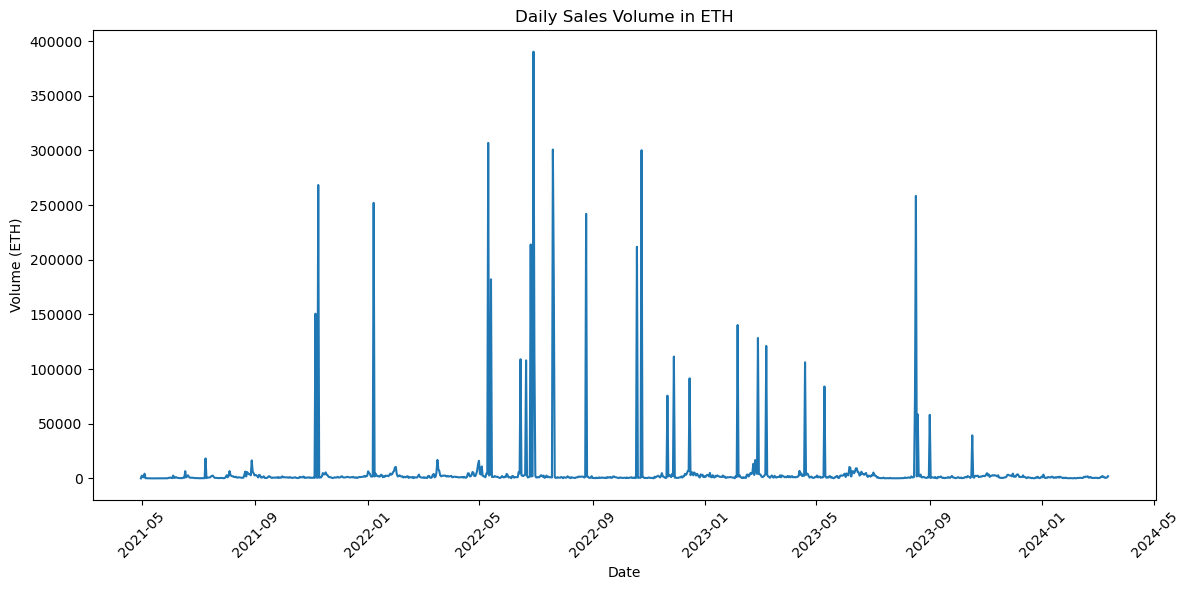

In [940]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sales volume over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_volume_over_time)
plt.title('Daily Sales Volume in ETH')
plt.xlabel('Date')
plt.ylabel('Volume (ETH)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [914]:
def fetch_nfts_by_collection_paginated(base_url, headers=None):
    session = requests_session_with_retries()
    all_data = []
    url = base_url
    
    while url:
        print(f"Requesting URL: {url}")
        response = session.get(url, headers=headers, timeout=30)
        
        if response.status_code == 200:
            data = response.json()
            nfts = data.get('nfts', [])
            all_data.extend(nfts)
            
            next_cursor = data.get('next', "")
            if next_cursor:
                url = f"{base_url}?next={next_cursor}"
            else:
                url = None
        else:
            print(f"Failed to fetch data from {url} - Status Code: {response.status_code}")
            break
            
    return pd.json_normalize(all_data)  # Convert the aggregated data to a DataFrame

In [916]:
nft_df = fetch_nfts_by_collection_paginated(get_nft_by_collection, headers)

Requesting URL: https://api.opensea.io/api/v2/collection/boredapeyachtclub/nfts
Requesting URL: https://api.opensea.io/api/v2/collection/boredapeyachtclub/nfts?next=LXBrPTIzMTQzNzAz
Requesting URL: https://api.opensea.io/api/v2/collection/boredapeyachtclub/nfts?next=LXBrPTIzMTQzNjUz
Requesting URL: https://api.opensea.io/api/v2/collection/boredapeyachtclub/nfts?next=LXBrPTIzMTQzNTkw
Requesting URL: https://api.opensea.io/api/v2/collection/boredapeyachtclub/nfts?next=LXBrPTIzMTQzNTM5
Requesting URL: https://api.opensea.io/api/v2/collection/boredapeyachtclub/nfts?next=LXBrPTIzMTQzNDgy
Requesting URL: https://api.opensea.io/api/v2/collection/boredapeyachtclub/nfts?next=LXBrPTIzMTQzNDI3
Requesting URL: https://api.opensea.io/api/v2/collection/boredapeyachtclub/nfts?next=LXBrPTIzMTQzMzc0
Requesting URL: https://api.opensea.io/api/v2/collection/boredapeyachtclub/nfts?next=LXBrPTIzMTQzMzE4
Requesting URL: https://api.opensea.io/api/v2/collection/boredapeyachtclub/nfts?next=LXBrPTIzMTQzMjY0
Re

In [917]:
nft_df

,identifier,collection,contract,token_standard,name,description,image_url,metadata_url,opensea_url,updated_at,is_disabled,is_nsfw
0,9661892397438820524199605562126265894452769816...,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,erc721,None,None,None,None,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2022-07-06T09:26:58.925803,False,False
1,313131313131,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,erc721,None,None,None,None,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2022-07-05T01:48:05.759785,False,False
2,9974,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,erc721,None,None,https://ipfs.io/ipfs/QmXHu7pFhp5sUJi1aajkmsgcF...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T04:00:41.600456,False,False
3,9973,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,erc721,None,None,https://ipfs.io/ipfs/QmNs7bSj8NyfHED8YjgFtQdvD...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T04:00:41.524108,False,False
4,9949,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,erc721,None,None,https://ipfs.io/ipfs/QmVb1n7vGzuVcGDXojSu6vRmi...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T03:39:21.051013,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9997,4,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,erc721,None,None,https://ipfs.io/ipfs/QmSg9bPzW9anFYc3wWU5Knvym...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T03:45:27.593661,False,False
9998,3,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,erc721,None,None,https://ipfs.io/ipfs/QmYxT4LnK8sqLupjbS6eRvu1s...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T03:45:27.492672,False,False
9999,2,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,erc721,None,None,https://ipfs.io/ipfs/QmcJYkCKK7QPmYWjp4FD2e3Lv...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T03:45:27.421122,False,False
10000,1,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,erc721,None,None,https://ipfs.io/ipfs/QmPbxeGcXhYQQNgsC6a36dDyY...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T03:45:27.345911,False,False


In [919]:
nft_df.drop(['token_standard', 'name', 'description', 'is_disabled', 'is_nsfw'], axis=1, inplace=True)

In [920]:
nft_df

,identifier,collection,contract,image_url,metadata_url,opensea_url,updated_at
0,9661892397438820524199605562126265894452769816...,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,None,None,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2022-07-06T09:26:58.925803
1,313131313131,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,None,None,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2022-07-05T01:48:05.759785
2,9974,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmXHu7pFhp5sUJi1aajkmsgcF...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T04:00:41.600456
3,9973,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmNs7bSj8NyfHED8YjgFtQdvD...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T04:00:41.524108
4,9949,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmVb1n7vGzuVcGDXojSu6vRmi...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T03:39:21.051013
...,...,...,...,...,...,...,...
9997,4,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmSg9bPzW9anFYc3wWU5Knvym...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T03:45:27.593661
9998,3,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmYxT4LnK8sqLupjbS6eRvu1s...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T03:45:27.492672
9999,2,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmcJYkCKK7QPmYWjp4FD2e3Lv...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T03:45:27.421122
10000,1,boredapeyachtclub,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://ipfs.io/ipfs/QmPbxeGcXhYQQNgsC6a36dDyY...,https://ipfs.io/ipfs/QmeSjSinHpPnmXmspMjwiXyN6...,https://opensea.io/assets/ethereum/0xbc4ca0eda...,2023-03-07T03:45:27.345911


In [ ]:
# I most likely need to get rid of the first two rows as they seem to be outliers and don't belong.

In [921]:
# Convert `updated_at` to datetime format
nft_df['updated_at'] = pd.to_datetime(nft_df['updated_at'])

# Fill or drop missing values (example: filling missing image_url with a placeholder)
nft_df['image_url'] = nft_df['image_url'].fillna("No Image Available")


In [923]:
# Count NFTs by contract address
nft_count_by_contract = nft_df['contract'].value_counts()

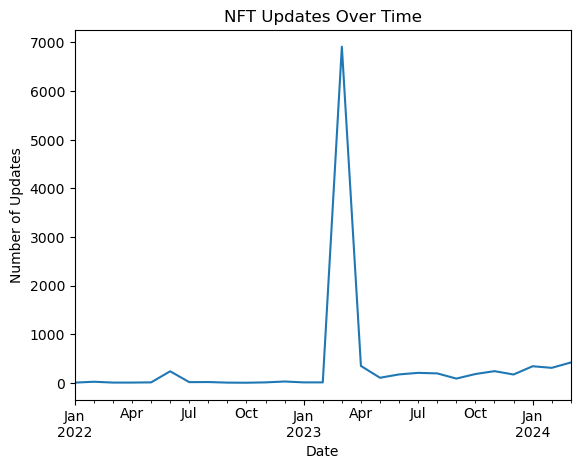

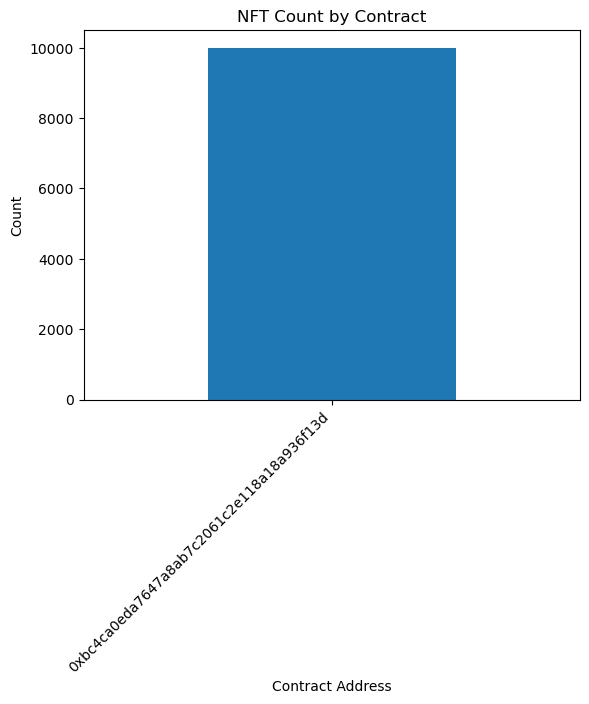

In [924]:
import matplotlib.pyplot as plt

# Visualize the number of NFT updates over time
nft_df.set_index('updated_at').resample('M').size().plot()
plt.title('NFT Updates Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Updates')
plt.show()

# Visualize NFT count by contract using a bar chart
nft_count_by_contract.plot(kind='bar')
plt.title('NFT Count by Contract')
plt.xlabel('Contract Address')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.show()


In [927]:
traits_json = fetch_api_data(get_traits, headers)

In [928]:
counts = {
    "Hat": {
        'Commie Hat': 304,
        'Bayc Flipped Brim': 231,
        "Fisherman's Hat": 345,
        "Girl's Hair Pink": 105,
        'Fez': 377,
        'Spinner Hat': 181,
        'Short Mohawk': 318,
        "Girl's Hair Short": 150,
        'Safari': 182,
        'Bayc Hat Black': 228,
        'S&m Hat': 235,
        'Cowboy Hat': 354,
        'Bowler': 262,
        'Police Motorcycle Helmet': 130,
        "Sea Captain's Hat": 304,
        'Sushi Chef Headband': 187,
        "Seaman's Hat": 420,
        'Stuntman Helmet': 157,
        'Army Hat': 294,
        'Halo': 324,
        'Party Hat 2': 107,
        'Horns': 252,
        'Party Hat 1': 120,
        'Beanie': 578,
        'Bunny Ears': 195,
        "Trippy Captain's Hat": 65,
        'Bandana Blue': 89,
        'Irish Boho': 225,
        "Baby's Bonnet": 158,
        'Ww2 Pilot Helm': 110,
        'Vietnam Era Helmet': 223,
        'Prussian Helmet': 130,
        'Bayc Hat Red': 119,
        'Laurel Wreath': 72,
        'Faux Hawk': 136,
        "King's Crown": 77
    },
    "Eyes": {
        'Crazy': 407,
        'Bloodshot': 846,
        'Sleepy': 751,
        'Sad': 551,
        'Zombie': 308,
        'Bored': 1714,
        'Cyborg': 108,
        'X Eyes': 243,
        'Angry': 432,
        'Wide Eyed': 549,
        'Scumbag': 233,
        'Coins': 479,
        '3d': 487,
        'Blue Beams': 49,
        'Closed': 710,
        'Hypnotized': 220,
        'Sunglasses': 352,
        'Eyepatch': 333,
        'Heart': 394,
        'Blindfold': 264,
        'Laser Eyes': 69,
        'Holographic': 151,
        'Robot': 350
    },
    "Background": {
        'Army Green': 1243,
        'Orange': 1273,
        'Gray': 1170,
        'New Punk Blue': 1232,
        'Aquamarine': 1266,
        'Purple': 1291,
        'Blue': 1242,
        'Yellow': 1283
    },
    "Fur": {
        'Blue': 490,
        'Black': 1229,
        'White': 397,
        'Gray': 496,
        'Dark Brown': 1352,
        'Cheetah': 406,
        'Robot': 265,
        'Pink': 511,
        'Solid Gold': 46,
        'Tan': 626,
        'Dmt': 215,
        'Noise': 155,
        'Brown': 1370,
        'Zombie': 302,
        'Golden Brown': 778,
        'Cream': 636,
        'Red': 474,
        'Death Bot': 175,
        'Trippy': 77
    },
    "Clothes": {
        'Puffy Vest': 227,
        'Work Vest': 188,
        'Prom Dress': 103,
        'Service': 142,
        'Black T': 334,
        'Leather Jacket': 206,
        'Biker Vest': 253,
        'Bone Necklace': 203,
        'Vietnam Jacket': 224,
        'Striped Tee': 412,
        'Black Holes T': 205,
        'Stunt Jacket': 178,
        'Bone Tee': 230,
        'Lumberjack Shirt': 213,
        'Rainbow Suspenders': 135,
        'Bayc T Black': 215,
        'Guayabera': 232,
        'Navy Striped Tee': 334,
        'Sailor Shirt': 284,
        'Prison Jumpsuit': 235,
        'Cowboy Shirt': 119,
        'Smoking Jacket': 221,
        'Hip Hop': 128,
        'Bayc T Red': 140,
        'Bandolier': 163,
        'Sleeveless T': 252,
        'Tweed Suit': 141,
        'Sleeveless Logo T': 144,
        'Caveman Pelt': 163,
        'Wool Turtleneck': 240,
        'Blue Dress': 95,
        'Tie Dye': 144,
        'Kings Robe': 68,
        'Tuxedo Tee': 235,
        'Leather Punk Jacket': 153,
        'Toga': 202,
        'Lab Coat': 144,
        'Tanktop': 235,
        'Pimp Coat': 80,
        'Hawaiian': 283,
        'Space Suit': 105,
        'Admirals Coat': 64,
        'Black Suit': 42
    },
    'Mouth': {
        'Phoneme L': 241,
        'Bored Pipe': 132,
        'Bored': 2272,
        'Dumbfounded': 505,
        'Tongue Out': 202,
        'Bored Cigarette': 710,
        'Discomfort': 208,
        'Phoneme  ooo': 255,
        'Jovial': 296,
        'Small Grin': 272,
        'Bored Unshaven Cigarette': 438,
        'Bored Cigar': 121,
        'Grin': 713,
        'Bored Unshaven': 1551,
        'Bored Unshaven Pipe': 101,
        'Bored Bubblegum': 119,
        'Rage': 266,
        'Bored Unshaven Cigar': 94,
        'Bored Unshaven Bubblegum': 65,
        'Bored Party Horn': 88,
        'Phoneme Vuh': 333,
        'Phoneme Wah': 163,
        'Phoneme Oh': 237,
        'Grin Gold Grill': 91,
        'Grin Multicolored': 116,
        'Grin Diamond Grill': 78,
        'Bored Pizza': 50,
        'Bored Unshaven Dagger': 28,
        'Bored Kazoo': 74,
        'Bored Dagger': 49,
        'Bored Unshaven Kazoo': 61,
        'Bored Unshaven Party horn': 45,
        'Bored Unshaven Pizza': 26
    },
    'Earring': {
        'Silver Hoop': 882,
        'Gold Stud': 439,
        'Cross': 149,
        'Gold Hoop': 462,
        'Silver Stud': 823,
        'Diamond Stud': 222
    }
}

In [929]:
hat_df = pd.DataFrame(list(counts['Hat'].items()), columns=['Hat', 'Count'])
eyes_df = pd.DataFrame(list(counts['Eyes'].items()), columns=['Eyes', 'Count'])
background_df = pd.DataFrame(list(counts['Background'].items()), columns=['Background', 'Count'])
fur_df = pd.DataFrame(list(counts['Fur'].items()), columns=['Fur', 'Count'])
clothes_df = pd.DataFrame(list(counts['Clothes'].items()), columns=['Clothes', 'Count'])
mouth_df = pd.DataFrame(list(counts['Mouth'].items()), columns=['Mouth', 'Count'])
earring_df = pd.DataFrame(list(counts['Earring'].items()), columns=['Earring', 'Count'])


In [930]:
print(hat_df.head())

                 Hat  Count
0         Commie Hat    304
1  Bayc Flipped Brim    231
2    Fisherman's Hat    345
3   Girl's Hair Pink    105
4                Fez    377


In [931]:
print(eyes_df.head())

        Eyes  Count
0      Crazy    407
1  Bloodshot    846
2     Sleepy    751
3        Sad    551
4     Zombie    308


In [932]:
print(background_df.head())

      Background  Count
0     Army Green   1243
1         Orange   1273
2           Gray   1170
3  New Punk Blue   1232
4     Aquamarine   1266


In [933]:
print(fur_df.head())

          Fur  Count
0        Blue    490
1       Black   1229
2       White    397
3        Gray    496
4  Dark Brown   1352


In [934]:
print(clothes_df.head())

      Clothes  Count
0  Puffy Vest    227
1   Work Vest    188
2  Prom Dress    103
3     Service    142
4     Black T    334


In [935]:
print(mouth_df.head())

         Mouth  Count
0    Phoneme L    241
1   Bored Pipe    132
2        Bored   2272
3  Dumbfounded    505
4   Tongue Out    202


In [936]:
print(earring_df.head())


       Earring  Count
0  Silver Hoop    882
1    Gold Stud    439
2        Cross    149
3    Gold Hoop    462
4  Silver Stud    823


In [937]:
rare_hats = hat_df.sort_values(by='Count', ascending=True).head(5)
print(rare_hats)

                     Hat  Count
25  Trippy Captain's Hat     65
33         Laurel Wreath     72
35          King's Crown     77
26          Bandana Blue     89
3       Girl's Hair Pink    105


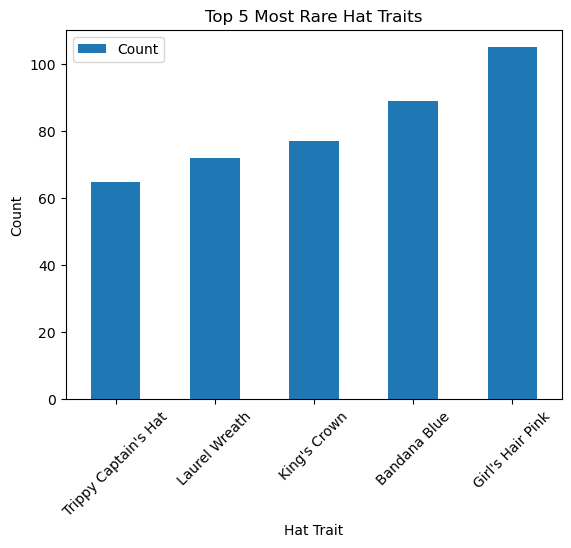

In [938]:
rare_hats.plot(kind='bar', x='Hat', y='Count')
plt.title('Top 5 Most Rare Hat Traits')
plt.ylabel('Count')
plt.xlabel('Hat Trait')
plt.xticks(rotation=45)
plt.show()